# Import Stuff

In [ ]:
!pip install newspaper3k

In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

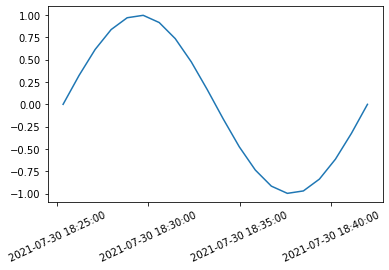

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import datetime as dt
import time

n=20
duration=1000
now=time.mktime(time.localtime())
timestamps=np.linspace(now,now+duration,n)
datenums=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
#datenums=md.date2num(dates)
values=np.sin((timestamps-now)/duration*2*np.pi)
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums,values)
plt.show()

# Code

In [ ]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMD', 'JNJ', 'PFE']

In [ ]:
news_tables = {}
for ticker in tickers:
  url = finviz_url + ticker

  # Requesting to see the data on the website.
  req = Request(url=url, headers={'user-agent': 'my-app'})
  response = urlopen(req)
  
  html = BeautifulSoup(response, 'html')
  #print(html) # Prints source code
  news_table = html.find(id='news-table')
  news_tables[ticker] = news_table

print(news_tables)

In [ ]:
amzn_data = news_tables['AMZN']
amzn_rows = amzn_data.findAll('tr')

for index, row in enumerate(amzn_rows):
  title = row.a.text # Look for the anchor tag and get the text within
  td = row.td.text
  print(td, " ", title) # Prints the title of each element.

KeyError: ignored

In [ ]:
parsed_data = []


for ticker, news_table in news_tables.items():
  for rows in news_table.findAll('tr'):
    title = rows.a.text
    date_data = rows.td.text.split(' ') # Split a thing that has a date and a time(June 2:00)
    
    if len(date_data) == 1: # If the string is just the time
      time = date_data[0]
    else: 
      date = date_data[0]
      time = date_data[1]
      
    parsed_data.append([ticker, date, time, title])

print(parsed_data)
    

[['AMD', 'Jul-30-21', '12:45PM\xa0\xa0', 'Here is Why Growth Investors Should Buy Advanced Micro (AMD) Now'], ['AMD', 'Jul-30-21', '12:30PM\xa0\xa0', "Here's Why AMD's Acquisition of Xilinx Is Such a Great Deal"], ['AMD', 'Jul-30-21', '11:30AM\xa0\xa0', '15 Best High Volume Stocks to Buy Now'], ['AMD', 'Jul-30-21', '10:30AM\xa0\xa0', 'Advanced Micro Devices Sees RS Rating Improve To 75 Following Breakout'], ['AMD', 'Jul-30-21', '10:05AM\xa0\xa0', "AMD's Q2 Results Have All The Chips In Place"], ['AMD', 'Jul-30-21', '05:20AM\xa0\xa0', 'Bull of the Day: Advanced Micro Devices (AMD)'], ['AMD', 'Jul-29-21', '11:30PM\xa0\xa0', 'AMD Radeon RX 6600 XT Graphics Card Sets New Standard for  High-Framerate, High-Fidelity 1080p PC Gaming'], ['AMD', 'Jul-29-21', '02:48PM\xa0\xa0', 'Why AMD Stock Surged Higher This Week'], ['AMD', 'Jul-29-21', '01:39PM\xa0\xa0', "AMD CEO: 'Demand for computing is exploding'"], ['AMD', 'Jul-29-21', '01:18PM\xa0\xa0', 'AMD stock surging to new record after Xilinx earn

In [ ]:
# Analyzing Sentiment

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

vader = SentimentIntensityAnalyzer()
print(vader.polarity_scores("The movie sucks ass."))
# positive sentiment : (compound score >= 0.05) 
# neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
# negative sentiment : (compound score <= -0.05)
# WE ONLY CARE ABOUT THE COMPOUND SCORE

{'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.7184}


In [ ]:
# Applying VADER on our dataframe

df['cmpd_score'] = [vader.polarity_scores(title)['compound'] for title in df['title']]

# f = lambda title: vader.polarity_scores(title)['compound'] same as ^^^
# df['compound'] = df['title'].apply(f)

df

                  cmpd_score
ticker time                 
AMD    01:00PM        0.0000
       01:02PM        0.2500
       01:18PM        0.0000
       01:21PM        0.0000
       01:39PM       -0.1280
...                      ...
PFE    12:15PM       -0.2960
       12:31PM        0.5256
       12:38PM        0.4767
       12:48PM        0.0000
       12:55PM        0.0429

[270 rows x 1 columns]
ticker      AMD     JNJ     PFE
time                           
01:00PM    0.00     NaN     NaN
01:02PM    0.25     NaN     NaN
01:05PM     NaN     NaN  0.3182
01:18PM    0.00     NaN     NaN
01:21PM    0.00 -0.0516     NaN
...         ...     ...     ...
12:48PM     NaN     NaN  0.0000
12:49PM     NaN  0.4019     NaN
12:55PM     NaN  0.0429  0.0429
12:58PM     NaN  0.4215     NaN
12:59PM    0.00     NaN     NaN

[223 rows x 3 columns]


<Figure size 36000x36000 with 0 Axes>

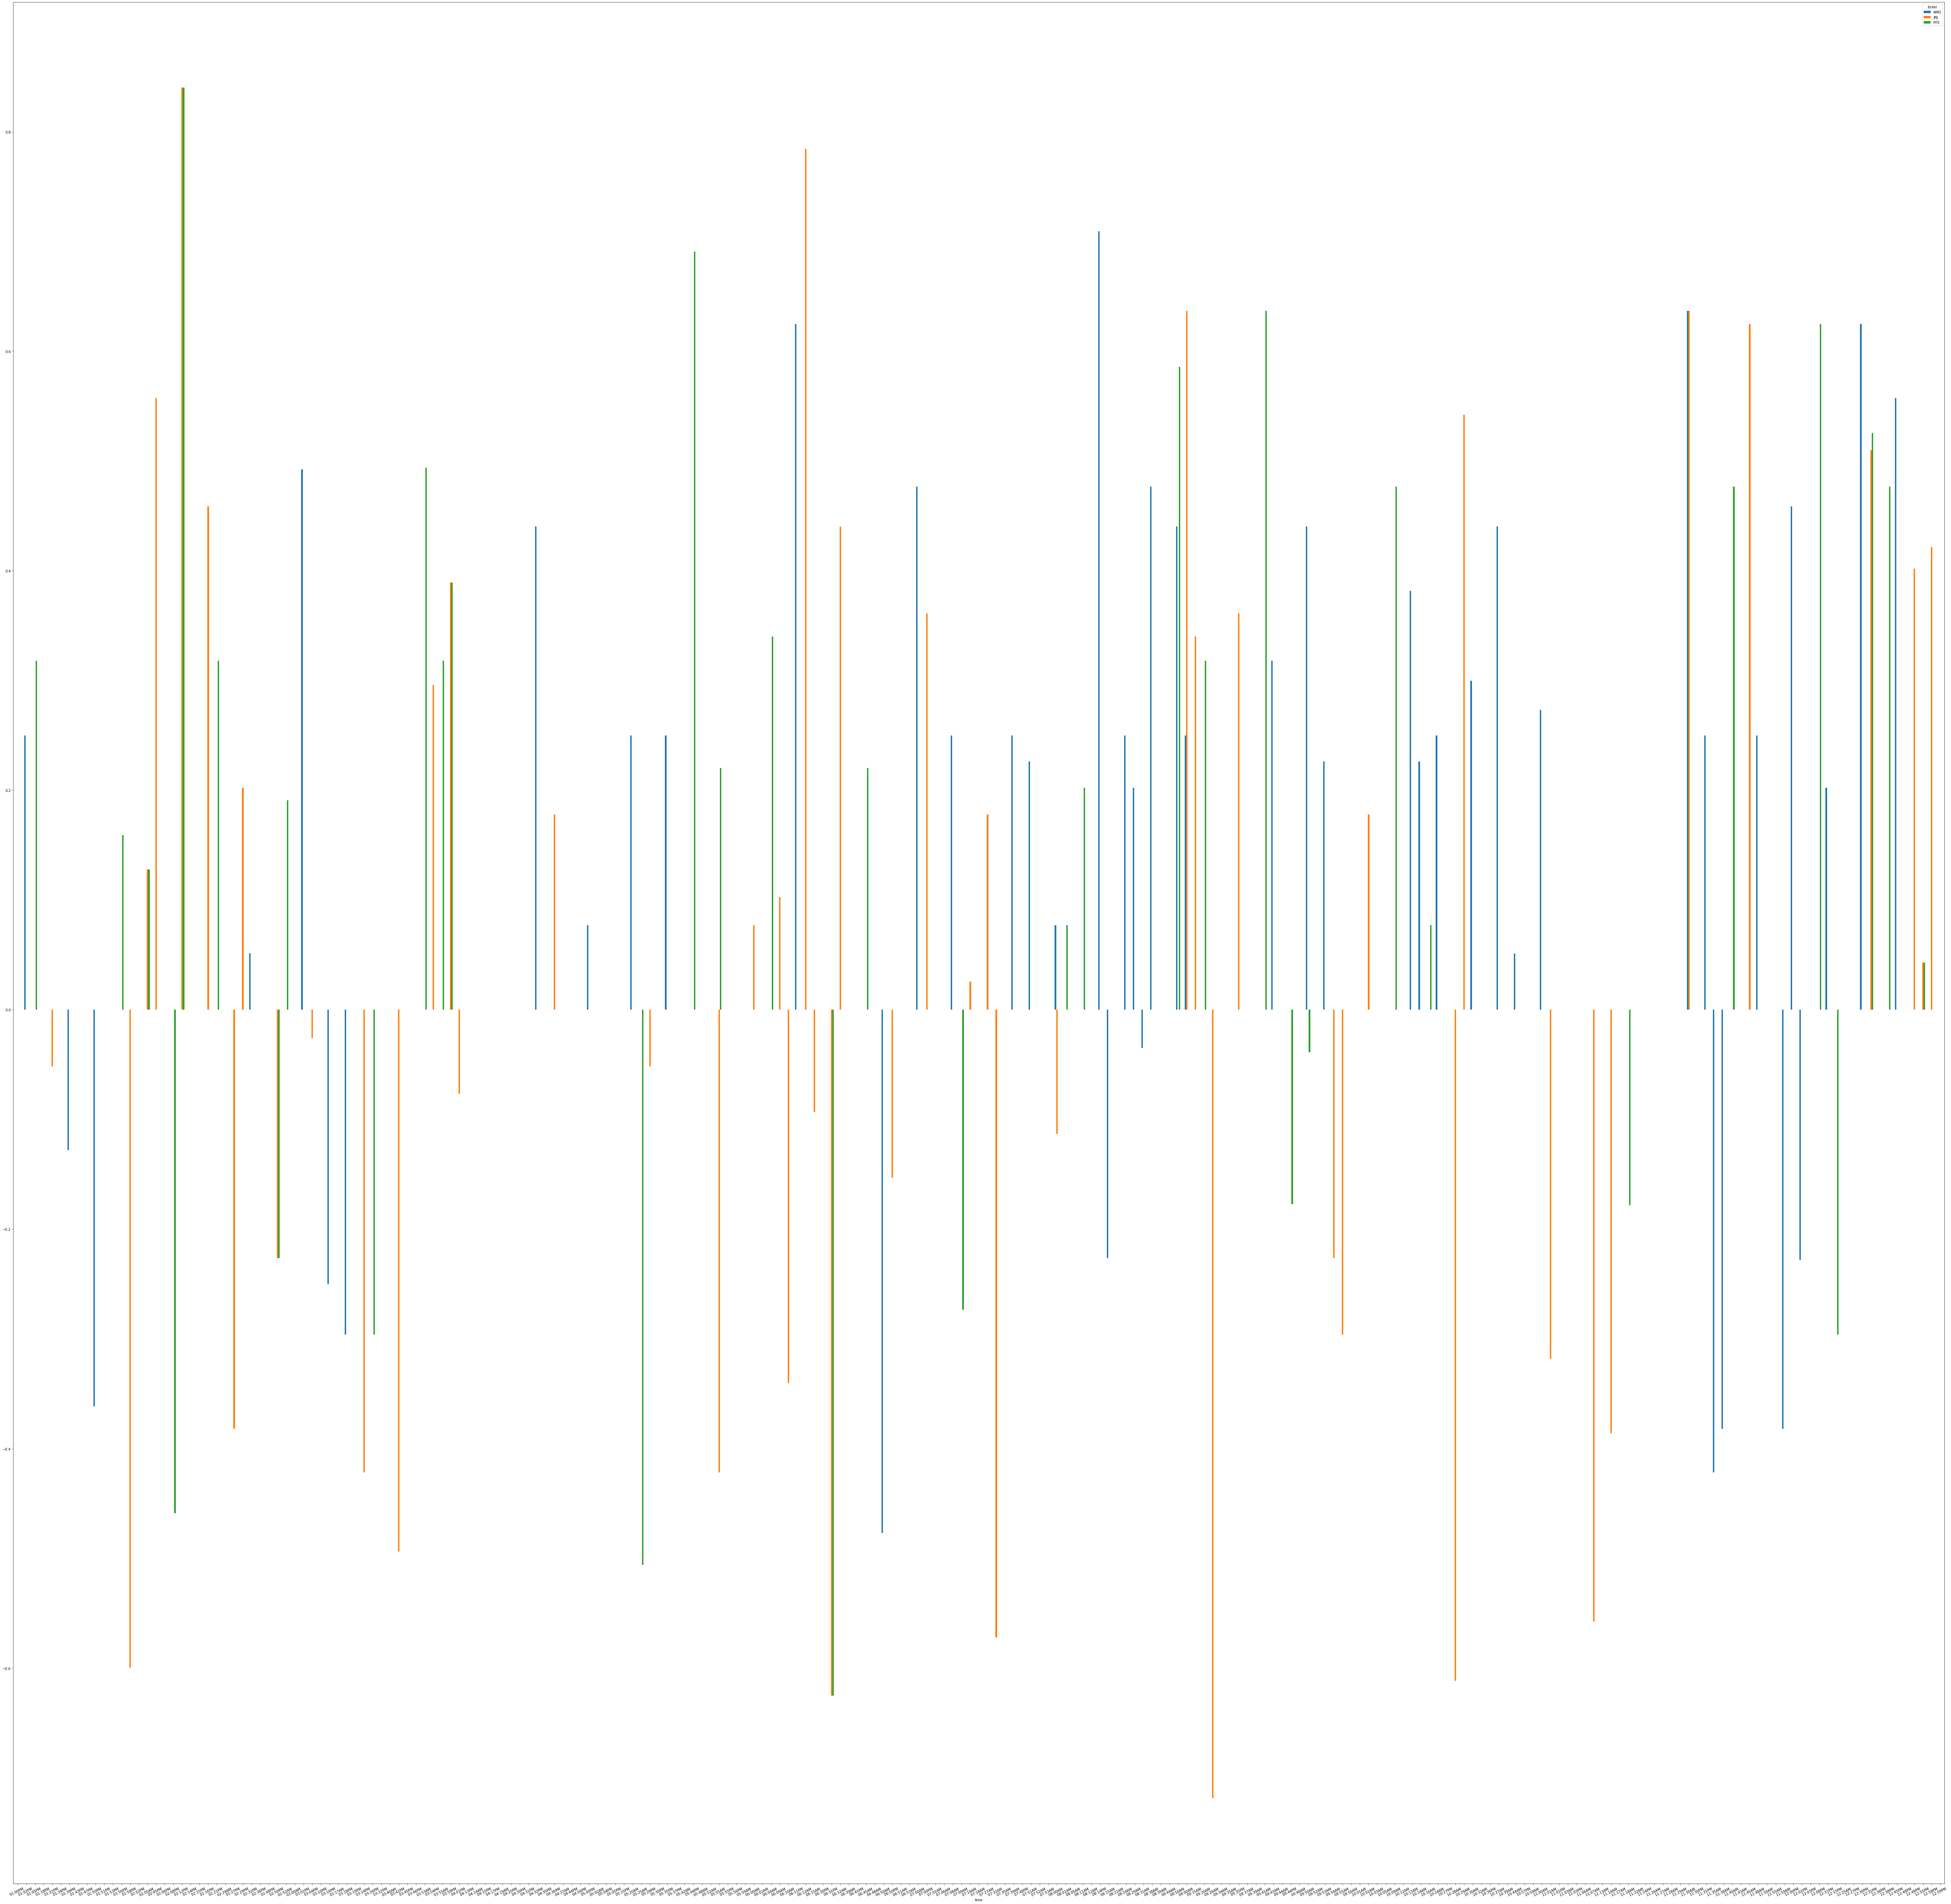

In [ ]:
# Plotting stocks and stuff

df['date'] = pd.to_datetime(df.date).dt.date

plt.figure(figsize=(500, 500))
mean_df = df.groupby(['ticker', 'time']).median() # Takes the mean of all the cmpds of a single date within a single ticker
print(mean_df)
mean_df = mean_df.unstack() # Unstacks the data
mean_df = mean_df.xs('cmpd_score', axis='columns').transpose() # Removing compound column
print(mean_df)
mean_df.plot(figsize=(100, 100), kind='bar')
plt.xticks( rotation=25 )
plt.show()